In [1]:
import os
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
class SoilDenseNet:
    """
    A class for implementing DenseNet for soil image classification.
    
    Attributes:
    -----------
    train_dir : str
        Path to the directory containing the training set.
    validation_dir : str
        Path to the directory containing the validation set.
    test_dir : str
        Path to the directory containing the test set.
    """
    
    def __init__(self, train_dir, validation_dir, test_dir):
        self.train_dir = train_dir
        self.validation_dir = validation_dir
        self.test_dir = test_dir
        self.num_classes = len(os.listdir(train_dir))
        self.target_size = (100, 100)  # DenseNet's input size
        self.batch_size = 32
        self.epochs = 80
        self.model = None

        # Set random seeds for reproducibility
        self.set_random_seeds()
    
    def set_random_seeds(self, seed_value=42):
        """
        Set random seeds for reproducibility.
        
        Parameters:
        -----------
        seed_value : int
            The seed value to use for all random number generators.
        """
        os.environ['PYTHONHASHSEED'] = str(seed_value)
        random.seed(seed_value)
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
    
    def build_model(self):
        """
        Build the DenseNet model.
        """
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

        # Freeze all the layers initially
        for layer in base_model.layers:
            layer.trainable = False

        # Unfreeze the last few layers for fine-tuning
        for layer in base_model.layers[-5:]:  # Fine-tuning fewer layers
            layer.trainable = True

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)  # Reduced number of units
        x = Dropout(0.15)(x)  
        x = Dense(self.num_classes, activation='softmax')(x)

        self.model = Model(inputs=base_model.input, outputs=x)
    
    def compile_model(self):
        """
        Compiles the DenseNet model.
        """
        initial_learning_rate = 0.0001
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=10000,
            decay_rate=0.96,
            staircase=True
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=1e-4)

        self.model.compile(optimizer=optimizer,
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    
    def train_model(self):
        """
        Trains the DenseNet model.
        """
        self.compile_model()

        train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

        train_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='categorical'
        )

        validation_generator = test_datagen.flow_from_directory(
            self.validation_dir,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='categorical'
        )

        checkpoint = ModelCheckpoint('soil_densenet_model.h5',
                                     monitor='val_accuracy',
                                     save_best_only=True,
                                     verbose=1)

        history = self.model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // self.batch_size,
            epochs=self.epochs,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // self.batch_size,
            callbacks=[checkpoint]
        )

        self.plot_training_history(history)
        return history

    def plot_training_history(self, history):
        """
        Plots the training and validation accuracy and loss curves.
        
        Parameters:
        -----------
        history : keras History
            History object containing training/validation metrics.
        """
        def smooth_curve(points, factor=0.9):
            smoothed_points = []
            for point in points:
                if smoothed_points:
                    previous = smoothed_points[-1]
                    smoothed_points.append(previous * factor + point * (1 - factor))
                else:
                    smoothed_points.append(point)
            return smoothed_points

        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(smooth_curve(history.history['accuracy']), label='Training Accuracy')
        plt.plot(smooth_curve(history.history['val_accuracy']), label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(smooth_curve(history.history['loss']), label='Training Loss')
        plt.plot(smooth_curve(history.history['val_loss']), label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.show()
    
    def evaluate_model(self):
        """
        Evaluate the trained DenseNet model on the test set and print the test accuracy.
        """
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
        test_generator = test_datagen.flow_from_directory(
            self.test_dir,
            target_size=self.target_size,
            batch_size=self.batch_size,
            class_mode='categorical',
            shuffle=False
        )
        
        self.model = tf.keras.models.load_model("soil_densenet_model.h5")
        
        start_time = time.time()
        test_loss, test_accuracy = self.model.evaluate(test_generator, verbose=1)
        end_time = time.time()
        
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
        print(f"Time taken to evaluate the model: {end_time - start_time} seconds")

## MODELING

Found 1096 images belonging to 4 classes.
Found 99 images belonging to 4 classes.
Epoch 1/80
34/34 [==============================] - ETA: 0s - loss: 1.3223 - accuracy: 0.4511
Epoch 1: val_accuracy improved from -inf to 0.40625, saving model to soil_densenet_model.h5


/Users/pranavramesh/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/34 [==============================] - 9s 206ms/step - loss: 1.3223 - accuracy: 0.4511 - val_loss: 1.2969 - val_accuracy: 0.4062
Epoch 2/80
34/34 [==============================] - ETA: 0s - loss: 0.9715 - accuracy: 0.6363
Epoch 2: val_accuracy improved from 0.40625 to 0.41667, saving model to soil_densenet_model.h5
34/34 [==============================] - 6s 184ms/step - loss: 0.9715 - accuracy: 0.6363 - val_loss: 1.1767 - val_accuracy: 0.4167
Epoch 3/80
34/34 [==============================] - ETA: 0s - loss: 0.9067 - accuracy: 0.6466
Epoch 3: val_accuracy improved from 0.41667 to 0.60417, saving model to soil_densenet_model.h5
34/34 [==============================] - 6s 184ms/step - loss: 0.9067 - accuracy: 0.6466 - val_loss: 1.0829 - val_accuracy: 0.6042
Epoch 4/80
34/34 [==============================] - ETA: 0s - loss: 0.8322 - accuracy: 0.6748
Epoch 4: val_accuracy improved from 0.60417 to 0.69792, saving model to soil_densenet_model.h5
34/34 [==============================] -

34/34 [==============================] - 11s 316ms/step - loss: 0.4773 - accuracy: 0.8336 - val_loss: 0.5100 - val_accuracy: 0.8438
Epoch 30/80
34/34 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.8280
Epoch 30: val_accuracy did not improve from 0.84375
34/34 [==============================] - 9s 277ms/step - loss: 0.4863 - accuracy: 0.8280 - val_loss: 0.4909 - val_accuracy: 0.8333
Epoch 31/80
34/34 [==============================] - ETA: 0s - loss: 0.4771 - accuracy: 0.8383
Epoch 31: val_accuracy did not improve from 0.84375
34/34 [==============================] - 10s 306ms/step - loss: 0.4771 - accuracy: 0.8383 - val_loss: 0.4595 - val_accuracy: 0.8229
Epoch 32/80
34/34 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.8402
Epoch 32: val_accuracy improved from 0.84375 to 0.85417, saving model to soil_densenet_model.h5
34/34 [==============================] - 12s 335ms/step - loss: 0.4683 - accuracy: 0.8402 - val_loss: 0.4812 - val_accur

Epoch 59/80
34/34 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8778
Epoch 59: val_accuracy did not improve from 0.86458
34/34 [==============================] - 9s 258ms/step - loss: 0.3667 - accuracy: 0.8778 - val_loss: 0.4411 - val_accuracy: 0.8646
Epoch 60/80
34/34 [==============================] - ETA: 0s - loss: 0.3608 - accuracy: 0.8759
Epoch 60: val_accuracy did not improve from 0.86458
34/34 [==============================] - 10s 281ms/step - loss: 0.3608 - accuracy: 0.8759 - val_loss: 0.4519 - val_accuracy: 0.8646
Epoch 61/80
34/34 [==============================] - ETA: 0s - loss: 0.3405 - accuracy: 0.8897
Epoch 61: val_accuracy improved from 0.86458 to 0.87500, saving model to soil_densenet_model.h5
34/34 [==============================] - 10s 294ms/step - loss: 0.3405 - accuracy: 0.8897 - val_loss: 0.4203 - val_accuracy: 0.8750
Epoch 62/80
34/34 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8844
Epoch 62: val_accuracy di

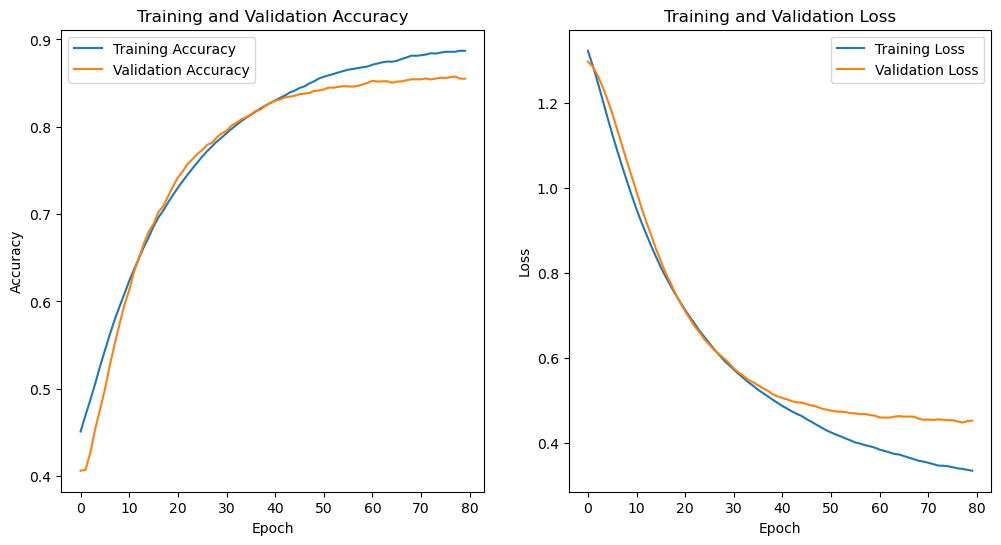

Found 97 images belonging to 4 classes.


4/4 [==============================] - 2s 183ms/step - loss: 0.3675 - accuracy: 0.8557
Test Accuracy: 85.57%
Time taken to evaluate the model: 1.631788969039917 seconds


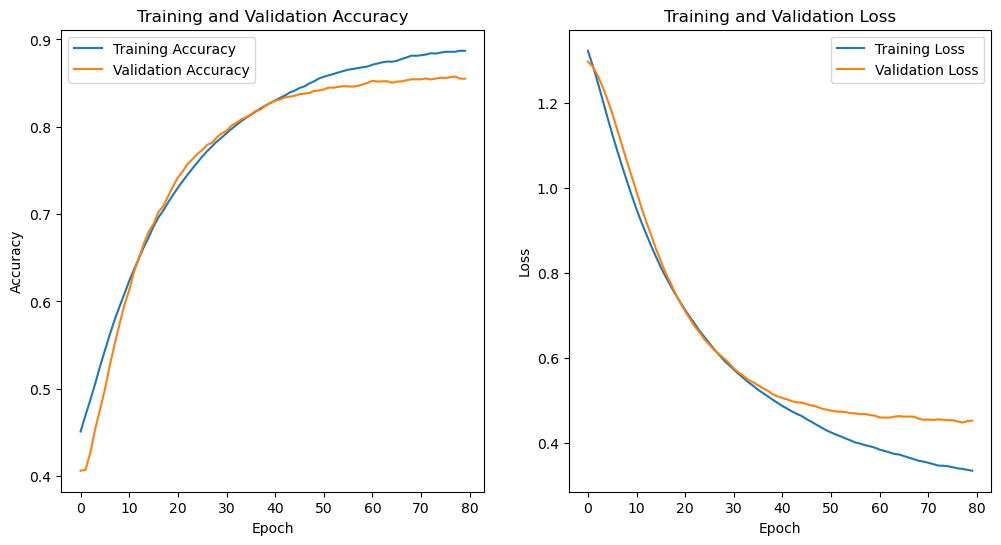

In [3]:
if __name__ == "__main__":
    # Build, train, and evaluate DenseNet model
    densenet_model = SoilDenseNet(train_dir='train_test_val/train',
                                  validation_dir='train_test_val/validation',
                                  test_dir='train_test_val/test')
    densenet_model.build_model()
    history = densenet_model.train_model()
    densenet_model.evaluate_model()

    # Plot the smoothed training history
    densenet_model.plot_training_history(history)